In [1]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import os
import shutil
import scipy as sp
import sys
from matplotlib import gridspec
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LogNorm

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics

FontSize=25
FontSizeLabelAxis=25
rc('legend',fontsize=FontSize)
rc('xtick',labelsize=FontSize)
rc('ytick',labelsize=FontSize)
font = {'family' : 'normal',
        'size'   : FontSize}

rc('font', **font)
rc('text', usetex=True)

# scaling factors
mm=1e3
MV=1e-6
kV=1e-3
mu0 = sp.constants.mu_0

cms = sp.constants.speed_of_light

time = 3.36678*10**-11
zloc = time*cms
print(zloc)

0.010093352517452399


In [2]:
direc = 'gaussian/notphilippe/notpoynt/19022_many_vdiff/'
direc = 'gaussian/notphilippe/notpoynt/19280_final/'
direc = 'gaussian/notphilippe/notpoynt/19376_angle40/'
direc = 'gaussian/notphilippe/notpoynt/19559_angle42p5/'
direc = 'gaussian/notphilippe/notpoynt/19374_angle45/'
direc = 'gaussian/notphilippe/notpoynt/19951_angle45_moredom/'
direc = 'gaussian/notphilippe/notpoynt/19956_angle45_Moredom/'
#direc = 'gaussian/notphilippe/notpoynt/19560_angle47p5/'
#direc = 'gaussian/notphilippe/notpoynt/19377_angle50/'
# has to be 1 less than reported number of diags, because of 0


direc = '1nC/1beam/3warpx/erika/25803_erika_quicklambda/'


Nitera = 3 # 78 650 500

txtfile = '/lstr/sahara/aard/cphillips/'+direc+'diags/reducedfiles/reduced_diags.txt'

filedir = '/lstr/sahara/aard/cphillips/'+direc+'diags/slabmovingwarpx/'



In [3]:
ts = LpaDiagnostics(filedir)
N_iterations = len(ts.iterations)
print(N_iterations)

11


# Calculating Poynting Vector

In [4]:
# Which dumps we want to look at
dumpmin = 599
dumpmax = 684

dumpmin = 480
dumpmax = 548

dumpmin = 70
dumpmax = 140

dumpmin = 5
dumpmax = 80

dumpmin = 3
dumpmax = 3

# Get the cell we want
# Currently groupings are at 45 degree angle; want 60 degrees
pvx = [0,-0.5,-1,-1.5,-2]
pvy = [0,-1.5,-3,-4.5,-6]
pvz = [100,101.5,103,104.5,106] #[100-(1+.4+.16] # structure len - cond_too_y


tslookat = np.arange(dumpmin,dumpmax+1,3)
print(tslookat)

[3]


In [25]:
# let's try to get groupings in 60 degrees
Len_hypo = 1.5 # mm
ang = 60 # degrees
num_groups = 5

struct_ang = 90
wall_depth = 0.4
cond_depthy = 1.203
vacgap = 1

rang = ang*np.pi/180
srang = struct_ang*np.pi/180

delz = Len_hypo*np.cos(rang)
dely = Len_hypo*np.sin(rang)
delx = Len_hypo*np.sin(rang/5)
# origin of the first arrow in x, y, z
orig = [0,0,100]

pvx = [orig[0] - i*delx for i in np.arange(num_groups)]
pvy = [orig[1] - i*dely for i in np.arange(num_groups)]
pvz = [orig[2] + i*delz - (vacgap+wall_depth+cond_depthy) for i in np.arange(num_groups)] # need to move inward from 100 because of the angle

tslookat = np.arange(dumpmin,dumpmax+1,3)

In [26]:
# let's just get the xyz min/max and PV for every ts first
alllocs = [] # going to be xsc, ysc, zsc
S_allx = []
S_ally = []
S_allz = []

for nit in tslookat:
    print(nit)

    it = ts.iterations[nit]
    
    Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                                slicing_dir='x', plot=False)
    Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                                slicing_dir='x', plot=False)
    Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                                slicing_dir='x', plot=False)
    Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                                slicing_dir='x', plot=False)
    By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                                slicing_dir='x', plot=False)
    Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                                slicing_dir='x',plot=False)
    alllocs.append([nit,info_Ez.xmin*mm, info_Ez.xmax*mm,info_Ez.ymin*mm, info_Ez.ymax*mm,info_Ez.zmin*mm, info_Ez.zmax*mm])
    print('Domain in z (mm): ',info_Ez.zmin*mm,info_Ez.zmax*mm)
    Sx = (1/mu0)*(Ey*Bz-Ez*By)
    Sy = (1/mu0)*(Ez*Bx-Ex*Bz)
    Sz = (1/mu0)*(Ex*By-Ey*Bx)
    S_allx.append(Sx)
    S_ally.append(Sy)
    S_allz.append(Sz)

    shapeSx = np.shape(Sx)
    print(shapeSx)
    shapeEz = np.shape(Ez)




3
Domain in z (mm):  -28.59800501031735 154.9551653223418
(2048, 256, 64)


### We now have the x,y,z components of the poynting vector at each grid point for each dump we specified
Future: \
change to just be info_Ez.xmin to info_Ez.xmax, since that's not different (see below)\
start below with x,y,z domain we want and then get all points within that plane

In [27]:
changelen = 0 # not including the last 2 cases, because they don't have the full range in z that we want 
lenarange = np.arange(len(tslookat)-changelen)

above = 3
below = 2

# Get the location of the center of the cells in x and y (same across dumps) and z for each dump
xsc = np.linspace(alllocs[0][1],alllocs[0][2],shapeEz[2])              # change to just be info_Ez.xmin to info_Ez.xmax, since that's not different at all? And then only save nit,zmin,zmax above?
ysc = np.linspace(alllocs[0][3],alllocs[0][4],shapeEz[1])
allzsc = [np.linspace(alllocs[i][5],alllocs[i][6],shapeEz[0]) for i in lenarange]
print(allzsc,len(allzsc[0]))
print('Domain: ')
print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)
print('zmin/max: ',info_Ez.zmin*mm, info_Ez.zmax*mm)

locx = []
locy = []
loczs = []
avgPVx = []
avgPVy = []
avgPVz = []

# Get the index closest to x=y=0 and closest to structure exit in z; also get the actual location and print out for knowledge
for i in np.arange(len(pvx)):
    indx = (np.abs(xsc - pvx[i])).argmin()
    indy = (np.abs(ysc - pvy[i])).argmin()
    indzs = (np.abs(allzsc - pvz[i])).argmin() #[(np.abs(allzsc[i] - pvz[i])).argmin() for i in lenarange]
    print('indzs: ',indzs)
    print(allzsc[0][indzs])
    locx.append(xsc[indx-below:indx+above])
    locy.append(ysc[indy-below:indy+above])
    loczs.append([allzsc[i][indzs-below:indzs+above] for i in lenarange][0])
    print('Goal location (x,y,z): ',pvx[i],pvy[i],pvz[i])
    print('Index (x,y,z): ',indx,indy,indzs)
    print('Actual location (x,y,z): ',locx[i], ' mm',locy[i],' mm',loczs[i],' mm')
    
    print(np.shape(S_allx))
    zeroPVx = [S_allx[i][indzs-below:indzs+above,indy-below:indy+above,indx-below:indx+above] for i in lenarange]
    zeroPVy = [S_ally[i][indzs-below:indzs+above,indy-below:indy+above,indx-below:indx+above] for i in lenarange]
    zeroPVz = [S_allz[i][indzs-below:indzs+above,indy-below:indy+above,indx-below:indx+above] for i in lenarange]
    
    print(np.shape(zeroPVx))
    print(np.shape(zeroPVy))
    print(np.shape(zeroPVz))
    
    print('locx, locy, loczs: ',locx,locy,loczs)
    print([np.mean(loczs) for i in np.arange(len(locx))])
    
    
    avgPVx.append(np.mean(zeroPVx,axis=0))
    avgPVy.append(np.mean(zeroPVy,axis=0))
    avgPVz.append(np.mean(zeroPVz,axis=0))

print(np.shape(avgPVx))



[array([-28.59800501, -28.50833566, -28.4186663 , ..., 154.77582661,
       154.86549597, 154.95516532])] 2048
Domain: 
xmin/max:  -2.9752734375 2.9752734375
ymin/max:  -17.56353515625 2.5635351562500013
zmin/max:  -28.59800501031735 154.9551653223418
indzs:  1405
97.38743920921665
Goal location (x,y,z):  0.0 0.0 97.397
Index (x,y,z):  31 223 1405
Actual location (x,y,z):  [-0.23613281 -0.14167969 -0.04722656  0.04722656  0.14167969]  mm [-0.12007422 -0.04114453  0.03778516  0.11671484  0.19564453]  mm [97.2081005  97.29776985 97.38743921 97.47710856 97.56677792]  mm
(1, 2048, 256, 64)
(1, 5, 5, 5)
(1, 5, 5, 5)
(1, 5, 5, 5)
locx, locy, loczs:  [array([-0.23613281, -0.14167969, -0.04722656,  0.04722656,  0.14167969])] [array([-0.12007422, -0.04114453,  0.03778516,  0.11671484,  0.19564453])] [array([97.2081005 , 97.29776985, 97.38743921, 97.47710856, 97.56677792])]
[97.38743920921665]
indzs:  1413
98.1047940517478
Goal location (x,y,z):  -0.311867536226639 -1.299038105676658 98.147
Inde

In [28]:
# Prepare data for plotting below; specifically along the structure exit
# get x,y,z 
xplotS = locx
yplotS = locy
zplotS = loczs #np.diagonal(loczs)
print(zplotS)
print(np.shape(xplotS),np.shape(yplotS),np.shape(zplotS))

PVxz_z = []
PVxz_x = []
PVyz_z = []
PVyz_y = []
angleydeg = []
anglexdeg = []
for i in np.arange(len(pvx)):
    # z-x Poynting Vector data
    PVxz_z.append(np.diagonal(avgPVz[i][:,2,:]))
    PVxz_x.append(np.diagonal(avgPVx[i][:,2,:]))
    
    # z-y Poynting Vector data
    PVyz_z.append(np.diagonal(avgPVz[i][:,:,1]))
    PVyz_y.append(np.diagonal(avgPVy[i][:,:,1]))
    
    angley = np.arctan(PVyz_y[i]/(-1*PVyz_z[i]))
    angleydeg.append(angley*180/np.pi)
    anglex = np.arctan(PVxz_x[i]/PVxz_z[i])
    anglexdeg.append(anglex*180/np.pi)



print('xz_x, yz_y, xz_z, yz_z')
print(PVxz_x)
print(PVyz_y)
print(PVxz_z)
print(PVyz_z)


print('Angle wrt y axis from bottom to top')
print(angleydeg)

print('Angle wrt x axis from bottom to top')
print(anglexdeg)

[array([97.2081005 , 97.29776985, 97.38743921, 97.47710856, 97.56677792]), array([97.92545534, 98.0151247 , 98.10479405, 98.19446341, 98.28413276]), array([98.73247954, 98.82214889, 98.91181825, 99.0014876 , 99.09115696]), array([99.44983438, 99.53950374, 99.62917309, 99.71884245, 99.8085118 ]), array([100.25685858, 100.34652793, 100.43619729, 100.52586665,
       100.615536  ])]
(5, 5) (5, 5) (5, 5)
xz_x, yz_y, xz_z, yz_z
[array([-45714162.88136593, -25097243.82850588, -14132702.80740537,
         3284058.67565075,  27833460.78906729]), array([1.13178077e+08, 8.68198536e+07, 5.48732142e+07, 2.43612007e+07,
       2.59844647e+06]), array([-29546377.88521577, -20184841.82328688, -11919396.82674881,
        -5393238.44120797,   -972698.06418353]), array([-26204246.09330234, -22531344.55259093, -18993527.37753755,
       -15693210.11916858, -12693892.22946808]), array([-28041718.7078258 , -27260059.17601531, -26414530.26085562,
       -25482231.58722618, -24436454.24829732])]
[array([-8.9

# Single dump calculations

In [29]:
#ts = LpaDiagnostics(filedir)

#N_iterations = len(ts.iterations)
#print(N_iterations)
if Nitera==-1:
   it = ts.iterations[N_iterations-1]
else:
   it = ts.iterations[Nitera]

# -------------------------------------------------------------------------
# retrieve the data from the hdf5 file for the electric and magnetic fields
# -------------------------------------------------------------------------
Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                            slicing_dir='x', plot=False)
Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                            slicing_dir='x', plot=False)
Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                            slicing_dir='x', plot=False)
Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                            slicing_dir='x', plot=False)
By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                            slicing_dir='x', plot=False)
Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                            slicing_dir='x',plot=False)
xf, yf, zf, px, py, pz = ts.get_particle( ['x','y','z','ux','uy','uz'],  species='myparticle', iteration=it)



shapeEz= np.shape(Ez)
print('z, y, x grid size: ',shapeEz)
absmax=MV*max(np.max(np.max(np.abs(Ez))),np.abs(np.min(np.min(np.abs(Ez)))))

xsc=np.linspace(info_Ez.xmin*mm, info_Ez.xmax*mm, shapeEz[2])
ysc=np.linspace(info_Ez.ymin*mm, info_Ez.ymax*mm, shapeEz[1])
zsc=np.linspace(info_Ez.zmin*mm, info_Ez.zmax*mm, shapeEz[0])


print('Domain:')
print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)
print('zmin/max: ',info_Ez.zmin*mm, info_Ez.zmax*mm)

print('zmean: ',np.round(np.mean(zf),6)*mm,' mm')
print('last particle z: ',np.round(np.min(zf),6)*mm,' mm')
print('x=y=0 structure exit in z: ',100-(1+.4+.16), ' mm')

print('first particle z: ',np.round(np.max(zf),6)*mm,' mm')

z, y, x grid size:  (2048, 256, 64)
Domain:
xmin/max:  -2.9752734375 2.9752734375
ymin/max:  -17.56353515625 2.5635351562500013
zmin/max:  -28.59800501031735 154.9551653223418
zmean:  142.36599999999999  mm
last particle z:  140.37199999999999  mm
x=y=0 structure exit in z:  98.44  mm
first particle z:  144.406  mm


In [38]:
# Get the range we want in x, y, and z
xlow = -1.55
xhigh = 1.55
xlow = info_Ez.xmin*mm # 60 50
xhigh = info_Ez.xmax*mm # 80
lenx = xhigh-xlow
xticklist = np.arange(xlow,xhigh+lenx/2,lenx/4)
xticklist = [round(i,1) for i in xticklist]
xindexmin = (np.abs(xsc - xlow)).argmin()
xindexmax = (np.abs(xsc - xhigh)).argmin()
print('x desired: ', xlow, xhigh, ' mm')
print('x acheived: ', xsc[xindexmin],xsc[xindexmax], ' mm')
print('xindexmin: ',xindexmin,' xindexmax: ',xindexmax)

# where is the slice for x=0?
xindex0 = (np.abs(xsc - 0)).argmin()
print('x = 0 acheived: ',xsc[xindex0], ' mm')
xindex0 = xindex0-xindexmin

ylow = -10
yhigh = 1.55
#ylow = info_Ez.ymin*mm # 60 50
#yhigh = info_Ez.ymax*mm # 80
leny = yhigh-ylow
yticklist = np.arange(ylow,yhigh+leny/2,leny/4)
yticklist = [round(i,1) for i in yticklist]
yindexmin = (np.abs(ysc - ylow)).argmin()
yindexmax = (np.abs(ysc - yhigh)).argmin()
print('y desired: ', ylow, yhigh, ' mm')
print('y acheived: ', ysc[yindexmin],ysc[yindexmax], ' mm')
print('y indexmin: ',yindexmin,' y indexmax: ',yindexmax)

# where is the slice for y=0?
yindex0 = (np.abs(ysc - 0)).argmin()
print('y = 0 acheived: ',ysc[yindex0], ' mm')
print('y = 0 index: ',yindex0)

zlow = 90
zhigh = 110
#zlow = info_Ez.zmin*mm
#zhigh = info_Ez.zmax*mm
lenz = zhigh-zlow-2
zticklist = np.arange(zlow+1,zhigh-1+lenz/2,lenz/4)
zticklist = [round(i,1) for i in zticklist]
print(zticklist)
zindexmin = (np.abs(zsc - zlow)).argmin()
zindexmax = (np.abs(zsc - zhigh)).argmin()
if zindexmin == 0:
    zindexmax = zindexmax-1
print('z desired: ', zlow, zhigh, ' mm')
print('z acheived: ', zsc[zindexmin],zsc[zindexmax], ' mm')
print('z indexmin: ',zindexmin,' z indexmax: ',zindexmax)

# higher number, larger gradient
mult = 1 

# pvplot = 0, no; 1, ; 2, 
pvplot = 2
pv2scale = 1000000000 # larger number = smaller arrows
#avg_PVn = [ 0.06160164, -0.51742454,  0.38209828] 
#avg_PV = [   357.15761471, -30179.31971494,  13167.58016861]

x desired:  -2.9752734375 2.9752734375  mm
x acheived:  -2.9752734375 2.9752734375  mm
xindexmin:  0  xindexmax:  63
x = 0 acheived:  -0.04722656249999968  mm
y desired:  -10 1.55  mm
y acheived:  -9.98628515625 1.5374492187500017  mm
y indexmin:  96  y indexmax:  242
y = 0 acheived:  0.03778515625000267  mm
y = 0 index:  223
[91.0, 95.5, 100.0, 104.5, 109.0, 113.5]
z desired:  90 110  mm
z acheived:  90.03455207327231 110.03081830882824  mm
z indexmin:  1323  z indexmax:  1546


index of y=0:  223
yloc we are able to get:  0.03778515625000267  mm
Angle wrt x axis from bottom to top
[array([-5.08324987, -2.34813987, -1.13761542,  0.23502961,  1.83675526]), array([ 36.44359165,  41.23731366,  48.99409578,  66.14114331,
       -63.26040218]), array([-8.46435296, -6.15125403, -4.08958538, -2.22990164, -0.5278362 ]), array([-20.7878598 , -18.94276099, -17.25049027, -15.67558161,
       -14.1661908 ]), array([-37.85413576, -35.10382462, -32.12008291, -28.95879053,
       -25.70652588])]
Angle wrt x axis from bottom to top
[array([-5.08324987, -2.34813987, -1.13761542,  0.23502961,  1.83675526]), array([ 36.44359165,  41.23731366,  48.99409578,  66.14114331,
       -63.26040218]), array([-8.46435296, -6.15125403, -4.08958538, -2.22990164, -0.5278362 ]), array([-20.7878598 , -18.94276099, -17.25049027, -15.67558161,
       -14.1661908 ]), array([-37.85413576, -35.10382462, -32.12008291, -28.95879053,
       -25.70652588])]
Angle wrt x axis from bottom to top
[array([-

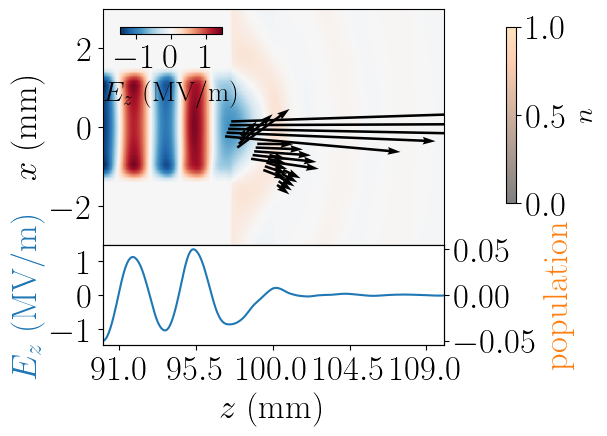

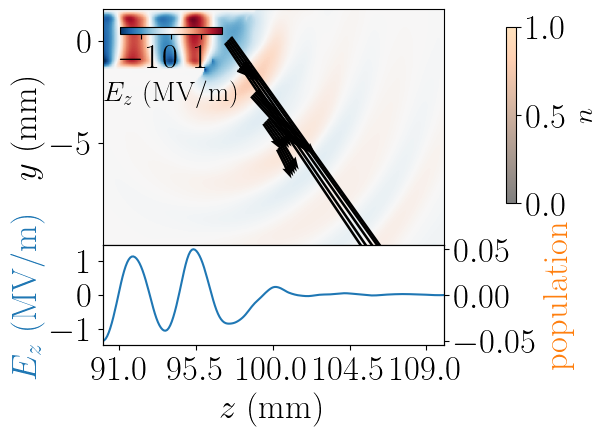

In [39]:
# PLOT POYNTING VECTOR?


# Center in y for offset structure; always want on axis
yloc = 0
index_y0 = (np.abs(ysc - yloc)).argmin()
print('index of y=0: ',index_y0)
print('yloc we are able to get: ',ysc[index_y0], ' mm')

# generate a plot of the Ez wake in (z,y) with lineout of Ez
fig=plt.figure(9999)
gs1 = gridspec.GridSpec(11, 13)
ax1 = fig.add_subplot(gs1[0:7,1:10])
ax2 = fig.add_subplot(gs1[7:10,1:10], sharex =ax1)
ax3 = fig.add_subplot(gs1[0:7,11:12])


# record Ez in the (z,x) plane for y=0
yEzslice=Ez[zindexmin:zindexmax,yindex0,xindexmin:xindexmax].transpose()*MV # gets the x=0 slice
yEzslice = np.flipud(yEzslice)
shapeyEzslice = np.shape(yEzslice)

yEabsmax = max(np.max(np.max(np.abs(yEzslice))),np.abs(np.min(np.min(np.abs(yEzslice)))))

# plot slice (upper plot with red and blue lines)
imField=ax1.imshow(yEzslice,extent=[zsc[zindexmin],zsc[zindexmax], xsc[xindexmin],xsc[xindexmax]],
                   cmap='RdBu_r', vmin=-yEabsmax/mult, vmax=yEabsmax/mult, aspect='auto')
cbaxes = inset_axes(ax1, width="30%", height="3%", loc=2)
cbar1  = fig.colorbar(imField, cax=cbaxes, orientation='horizontal').set_label(label=r'$E_z$ (MV/m)',size=20)
ax1.set_ylabel(r'$x$ (mm)', fontsize=FontSizeLabelAxis)

# record particle and plot a histogram on top of 3d of Ez - NEED TO ADJUST AXES FOR THIS
particles=ax1.hexbin(zf*mm, xf*mm, gridsize=200,extent=[zsc[zindexmin],zsc[zindexmax], xsc[xindexmin],xsc[xindexmax]], cmap='copper', alpha=0.5,  mincnt=5)
ax3.axis('off')
cbaxes2 = inset_axes(ax3, width="30%", height="75%", loc=2)
cbar2 = fig.colorbar(particles, cax=cbaxes2).set_label(label=r'$n$ ',size=20)

if pvplot == 1:
    pv = ax1.quiver(loczs,locx,PV[2],PV[0],color='g',scale=3)
elif pvplot ==2:
    for i in np.arange(len(pvx)):
        pv = ax1.quiver(zplotS[i],xplotS[i],PVxz_z[i],PVxz_x[i],color='k',scale=pv2scale)
        print('Angle wrt x axis from bottom to top')
        print(anglexdeg)

    


# Line plot of Ez plus histogram of the population on lower plot
zsca=np.linspace(zsc[zindexmin],zsc[zindexmax], zindexmax-zindexmin)
print(np.shape(yEzslice))
ax2.plot (zsca,yEzslice[xindex0,:]) # gets the y=0 slice
ax2.set_xlabel(r'$z$ (mm)', fontsize=FontSizeLabelAxis)
ax2.set_ylabel(r'$E_z$ (MV/m) ', fontsize=FontSizeLabelAxis, color="C0")
ax2.set_xticks(zticklist)
ax22 = ax2.twinx()
ax22.hist(zf*mm,shapeEz[0], range=(zsc[zindexmin],zsc[zindexmax]),alpha=0.3, color='C1')
ax22.set_ylabel(r'population', fontsize=FontSizeLabelAxis, color="C1")

# Set up the plots
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(hspace=.0)

# Save the plot to be viewed
#plt.savefig(save_dir+fig9999)
#plt.savefig(save_dir+fig9999p,dpi=600)
#plt.savefig(plotnms[pn]+'x.png')
plt.show()



#-------------------------------------------------------------------------
# record Ez in the (z,y) plane for x=0
fig=plt.figure(9998)
gs1 = gridspec.GridSpec(11, 13)
ax1 = fig.add_subplot(gs1[0:7,1:10])
ax2 = fig.add_subplot(gs1[7:10,1:10], sharex =ax1)
ax3 = fig.add_subplot(gs1[0:7,11:12])

# record Ez in the (z,y) plane for x=0
xEzslice=Ez[zindexmin:zindexmax,yindexmin:yindexmax,xindex0].transpose()*MV # gets the x=0 sliceplt.gca().invert_yaxis()
xEzslice = np.flipud(xEzslice)
shapexEzslice = np.shape(xEzslice)
xEabsmax = max(np.max(np.max(np.abs(xEzslice))),np.abs(np.min(np.min(np.abs(xEzslice)))))

# plot slice (upper plot with red and blue lines)
imField=ax1.imshow(xEzslice,extent=[zsc[zindexmin],zsc[zindexmax], ysc[yindexmin],ysc[yindexmax]],
                   cmap='RdBu_r', vmin=-xEabsmax/mult, vmax=xEabsmax/mult, aspect='auto')
cbaxes = inset_axes(ax1, width="30%", height="3%", loc=2)
cbar1  = fig.colorbar(imField, cax=cbaxes, orientation='horizontal').set_label(label=r'$E_z$ (MV/m)',size=20)
ax1.set_ylabel(r'$y$ (mm)', fontsize=FontSizeLabelAxis)
plt.gca().invert_yaxis()

# record particle and plot a histogram on top of 3d of Ez
particles=ax1.hexbin(zf*mm, yf*mm, gridsize=200,extent=[zsc[zindexmin],zsc[zindexmax], ysc[yindexmin],ysc[yindexmax]], cmap='copper', alpha=0.5,  mincnt=5)
ax3.axis('off')
cbaxes2 = inset_axes(ax3, width="30%", height="75%", loc=2)
cbar2 = fig.colorbar(particles, cax=cbaxes2).set_label(label=r'$n$ ',size=20)

if pvplot == 1:
    pv = ax1.quiver(loczs,locy,PV[2],PV[1],color='g',scale=3)
elif pvplot ==2:
    for i in np.arange(len(pvx)):
        pv = ax1.quiver(zplotS[i],yplotS[i],PVyz_z[i],PVyz_y[i],color='k',scale=pv2scale)
#    print('Angle wrt y axis from bottom to top')
#    print(angleydeg)


#zplotS,xplotS,avgPVz[1,:],avgPVx[1,:]

# Line plot of Ez plus histogram of the population on lower plot
zscb=np.linspace(zsc[zindexmin],zsc[zindexmax], zindexmax-zindexmin)
nyindex0 = yindex0-yindexmin
ax2.plot (zscb,xEzslice[shapexEzslice[0]-nyindex0,:]) #int(shapeEzslice[0]/2),:]) # Ez slice has shape (ylen,zlen)
#ax2.plot (zscb,Ey[16,48,:]*1e-6)
#ax2.plot (zscb,Ex[16,48,:]*1e-6)
ax2.set_xlabel(r'$z$ (mm)', fontsize=FontSizeLabelAxis)
ax2.set_ylabel(r'$E_z$ (MV/m) ', fontsize=FontSizeLabelAxis, color="C0")
ax2.set_xticks(zticklist)
ax22 = ax2.twinx()
ax22.hist(zf*mm,shapeEz[0], range=(zsc[zindexmin],zsc[zindexmax]),alpha=0.3, color='C1')
ax22.set_ylabel(r'population', fontsize=FontSizeLabelAxis, color="C1")

# Set up the plots
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(hspace=.0)

# Save the plot to be viewed
#plt.savefig(save_dir+fig9998)
#plt.savefig(save_dir+fig9998p,dpi=600)
#plt.savefig(plotnms[pn]+'y.png')
plt.show()



In [23]:
print('Angle wrt y axis')
angley = np.arctan(PVyz_y[0]/PVyz_z[0])*180/np.pi
print(PVyz_z)
print(PVyz_y)
print(angley)
print(-PVyz_y[0])


Angle wrt y axis


NameError: name 'PVyz_y' is not defined

In [ ]:
# poynting vector calc
# poynting vector from this point
pvx = 0
pvy = 0
pvz = 100-(1+.4+.16) # structure len - cond_too_y
print('Goal location (x,y,z): ',pvx,pvy,pvz)

# get closest (x,y,z) index
indx = (np.abs(xsc - pvx)).argmin()
indy = (np.abs(ysc - pvy)).argmin()
indz = (np.abs(zsc - pvz)).argmin()
locx = xsc[indx]
locy = ysc[indy]
locz = zsc[indz]
print('Index (x,y,z): ',indx,indy,indz)
print('Actual location (x,y,z): ',locx,locy,locz)

print(np.shape(Ex),np.shape(Ey),np.shape(Ez),np.shape(Bx),np.shape(By),np.shape(Bz))

Ex_0 = Ex[indz,indy,indx]
Ey_0 = Ey[indz,indy,indx]
Ez_0 = Ez[indz,indy,indx]
Bx_0 = Bx[indz,indy,indx]
By_0 = By[indz,indy,indx]
Bz_0 = Bz[indz,indy,indx]

# poynting vector is (1/mu_0) E_vec X B_vec
pv_x = (1/mu0)*(Ey_0*Bz_0 - Ez_0*By_0)*MV
pv_y = (1/mu0)*(Ez_0*Bx_0 - Ex_0*Bz_0)*MV
pv_z = (1/mu0)*(Ex_0*By_0 - Ey_0*Bx_0)*MV
print(pv_x,pv_y,pv_z, 'MV')
PVx = np.linspace(0,pv_x,100)
PVy = np.linspace(0,pv_y,100)
PVz = np.linspace(0,pv_z,100)
#PV = [[0,pv_x],[0,pv_y],[0,pv_z]]

tot = np.sqrt(pv_x**2 + pv_y**2 + pv_z**2)
print(tot)

PVnx = pv_x/tot
PVny = pv_y/tot
PVnz = pv_z/tot
PV = [pv_x,pv_y,pv_z] # not normalized to 1; not unit vector
PV = [PVnx,PVny,PVnz] # normalized to 1; unit vector
print(PV)

In [15]:
lenarange = np.arange(len(tslookat))

shapeEz = np.shape(allfields[0][3])
print('z, y, x grid size: ',shapeEz)
absmax=MV*max(np.max(np.max(np.abs(allfields[0][3]))),np.abs(np.min(np.min(np.abs(allfields[0][3])))))



# We don't just want the closest index, but we want the surrounding indices as well; let's not change z for now 
xindices = np.arange(indx-1,indx+3)
print(xsc[indx-1:indx+3])
print(ysc[indy-1:indy+3])


zeroFields = [[allfields[i][0],allfields[i][1][indzs[i],indy,indx],allfields[i][2][indzs[i],indy,indx],allfields[i][3][indzs[i],indy,indx],
               allfields[i][4][indzs[i],indy,indx],allfields[i][5][indzs[i],indy,indx],allfields[i][6][indzs[i],indy,indx]] for i in lenarange]


# poynting vector calc
# poynting vector is (1/mu_0) E_vec X B_vec
pv_x = [(1/mu0)*(zeroFields[i][2]*zeroFields[i][6] - zeroFields[i][3]*zeroFields[i][5])*MV for i in lenarange]
pv_y = [(1/mu0)*(zeroFields[i][3]*zeroFields[i][4] - zeroFields[i][1]*zeroFields[i][6])*MV for i in lenarange]
pv_z = [(1/mu0)*(zeroFields[i][1]*zeroFields[i][5] - zeroFields[i][2]*zeroFields[i][4])*MV for i in lenarange]

avgPVx = np.mean(pv_x)
avgPVy = np.mean(pv_y)
avgPVz = np.mean(pv_z)

avg_PV = [avgPVx,avgPVy,avgPVz]
print(avg_PV)

tots = [np.sqrt(pv_x[i]**2 + pv_y[i]**2 + pv_z[i]**2) for i in lenarange]
PVnxs = [pv_x[i]/tots[i] for i in lenarange]
PVnys = [pv_y[i]/tots[i] for i in lenarange]
PVnzs = [pv_z[i]/tots[i] for i in lenarange]

PVns = [[PVnxs[i],PVnys[i],PVnzs[i]] for i in lenarange]

avg_PVn = np.mean(PVns,axis=0)

z, y, x grid size:  (512, 128, 64)
Domain: 
xmin/max:  -1.5356249999999998 1.5356249999999998
ymin/max:  -5.470703124999999 1.9707031250000007
zmin/max:  90.4085090092162 116.4575080576092
[319, 315, 310, 305, 300, 296, 291, 286, 281, 277, 272, 267, 262, 258, 253, 248, 244, 239, 234, 229, 225, 220, 215, 210, 206, 201, 196, 191, 187, 182, 177, 173, 168, 163, 158, 154, 149, 144, 139, 135, 130, 125, 120, 116, 111, 106, 102, 97, 92, 87, 83, 78, 73, 68, 64, 59, 54, 49, 45, 40, 35, 31, 26, 21, 16, 12, 7, 2, 0]
Goal location (x,y,z):  0 0 98.44
Index (x,y,z):  31 93 [319, 315, 310, 305, 300, 296, 291, 286, 281, 277, 272, 267, 262, 258, 253, 248, 244, 239, 234, 229, 225, 220, 215, 210, 206, 201, 196, 191, 187, 182, 177, 173, 168, 163, 158, 154, 149, 144, 139, 135, 130, 125, 120, 116, 111, 106, 102, 97, 92, 87, 83, 78, 73, 68, 64, 59, 54, 49, 45, 40, 35, 31, 26, 21, 16, 12, 7, 2, 0]
Actual location (x,y,z):  -0.024375000000000036  mm -0.021484374999999112  mm [98.46279834316216, 98.462798343162

In [10]:
# allPV
dumpmin = 599
dumpmax = 684






all_PVn = [] # unit vector
all_PV = [] # not normalized

print(np.arange(dumpmin,dumpmax+1))

# let's just get the PV for every ts first
for nit in np.arange(dumpmin,dumpmax+1):
    print(nit)
    ts = LpaDiagnostics(filedir)
    
    N_iterations = len(ts.iterations)
    it = ts.iterations[nit]
    
    Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                                slicing_dir='x', plot=False)
    Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                                slicing_dir='x', plot=False)
    Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                                slicing_dir='x', plot=False)
    Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                                slicing_dir='x', plot=False)
    By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                                slicing_dir='x', plot=False)
    Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                                slicing_dir='x',plot=False)
    
    
    shapeEz= np.shape(Ez)
    print('z, y, x grid size: ',shapeEz)
    absmax=MV*max(np.max(np.max(np.abs(Ez))),np.abs(np.min(np.min(np.abs(Ez)))))
    
    xsc=np.linspace(info_Ez.xmin*mm, info_Ez.xmax*mm, shapeEz[2])
    ysc=np.linspace(info_Ez.ymin*mm, info_Ez.ymax*mm, shapeEz[1])
    zsc=np.linspace(info_Ez.zmin*mm, info_Ez.zmax*mm, shapeEz[0])
    
    print('Domain:')
    print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
    print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)
    print('zmin/max: ',info_Ez.zmin*mm, info_Ez.zmax*mm)
    
    # poynting vector calc
    # poynting vector from this point
    pvx = 0
    pvy = 0
    pvz = 100-(1+.4+.16) # structure len - cond_too_y
    print('Goal location (x,y,z): ',pvx,pvy,pvz)
    
    # get closest (x,y,z) index
    indx = (np.abs(xsc - pvx)).argmin()
    indy = (np.abs(ysc - pvy)).argmin()
    indz = (np.abs(zsc - pvz)).argmin()
    locx = xsc[indx]
    locy = ysc[indy]
    locz = zsc[indz]
    print('Index (x,y,z): ',indx,indy,indz)
    print('Actual location (x,y,z): ',locx,locy,locz)
    
    
    Ex_0 = Ex[indz,indy,indx]
    Ey_0 = Ey[indz,indy,indx]
    Ez_0 = Ez[indz,indy,indx]
    Bx_0 = Bx[indz,indy,indx]
    By_0 = By[indz,indy,indx]
    Bz_0 = Bz[indz,indy,indx]
    
    # poynting vector is (1/mu_0) E_vec X B_vec
    pv_x = (1/mu0)*(Ey_0*Bz_0 - Ez_0*By_0)*MV
    pv_y = (1/mu0)*(Ez_0*Bx_0 - Ex_0*Bz_0)*MV
    pv_z = (1/mu0)*(Ex_0*By_0 - Ey_0*Bx_0)*MV
    print(pv_x,pv_y,pv_z, 'MV')
    PVx = np.linspace(0,pv_x,100)
    PVy = np.linspace(0,pv_y,100)
    PVz = np.linspace(0,pv_z,100)
    
    tot = np.sqrt(pv_x**2 + pv_y**2 + pv_z**2)
    print(tot)
    
    PVnx = pv_x/tot
    PVny = pv_y/tot
    PVnz = pv_z/tot
    PVn = [PVnx,PVny,PVnz]
    PV = [pv_x,pv_y,pv_z]
    all_PVn.append(PVn)
    all_PV.append(PV)

# calc average poynting vector
avg_PVn = np.mean(all_PVn,axis=0)
avg_PV = np.mean(all_PV,axis=0)
print(avg_PVn,avg_PV)

[599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652
 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670
 671 672 673 674 675 676 677 678 679 680 681 682 683 684]
599


KeyboardInterrupt: 

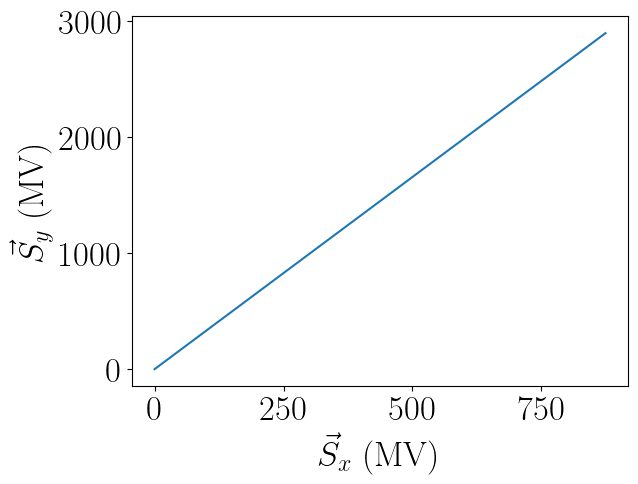

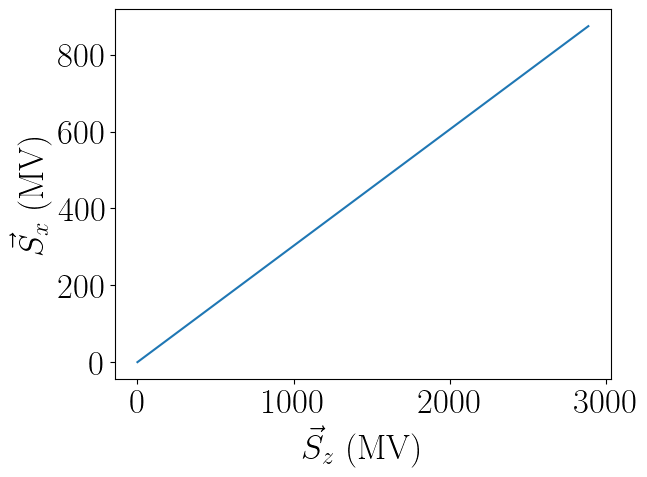

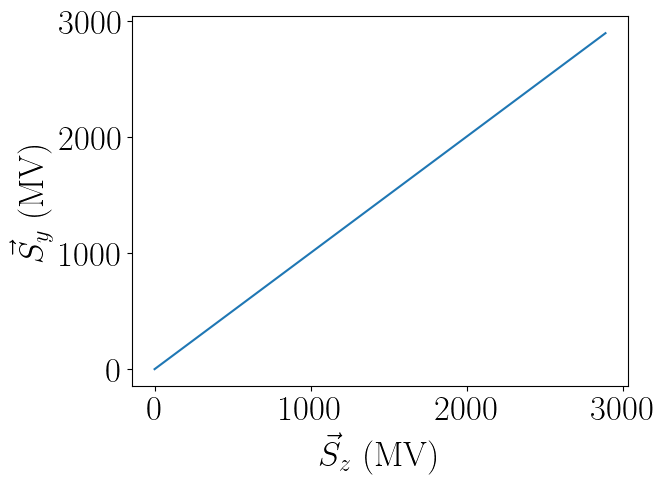

In [59]:
plt.plot(PVx,PVy)
plt.xlabel(r'$\vec{S}_x$ (MV)')
plt.ylabel(r'$\vec{S}_y$ (MV)')
plt.show()

plt.plot(PVz,PVx)
plt.xlabel(r'$\vec{S}_z$ (MV)')
plt.ylabel(r'$\vec{S}_x$ (MV)')
plt.show()

plt.plot(PVz,PVy)
plt.xlabel(r'$\vec{S}_z$ (MV)')
plt.ylabel(r'$\vec{S}_y$ (MV)')
plt.show()



